In [32]:
import os 
import re
import pickle
import collections
import sklearn 

import skimage.io
import skimage.color
import skimage.feature
import skimage.transform
import sklearn.metrics

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from glob import glob
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline


%matplotlib inline

In [2]:
# Load the data 

In [3]:
data = pickle.load(open('data_animals_head_20.pickle','rb'))
data.keys()

dict_keys(['description', 'data', 'target', 'labels'])

In [4]:
data['description']

'There are 20 classes and 2023 images of size 80x80x3'

In [5]:
#split the data 
X = data['data']
y = data['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y )

In [7]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((1618, 80, 80, 3), (405, 80, 80, 3), 1618, 405)

In [8]:
# Feature Extraction 

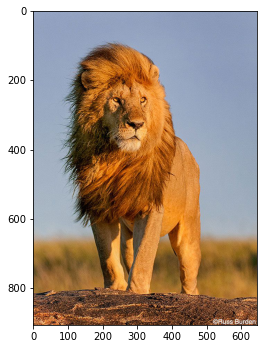

In [9]:
img = skimage.io.imread('images/lion.bmp')
plt.figure(figsize=(4,6))
plt.imshow(img)

In [10]:
# hog transform
img_re = skimage.transform.rescale(img, 1/3, multichannel=True)
gray = skimage.color.rgb2gray(img_re)
feature_vector, hog_img = skimage.feature.hog(
    gray,
    orientations=9,
    pixels_per_cell=(14, 14),
    cells_per_block=(2, 2),
    visualize=True,)

In [11]:
print(len(feature_vector))
print(gray.shape, gray.shape[0]*gray.shape[1])

10080
(302, 215) 64930


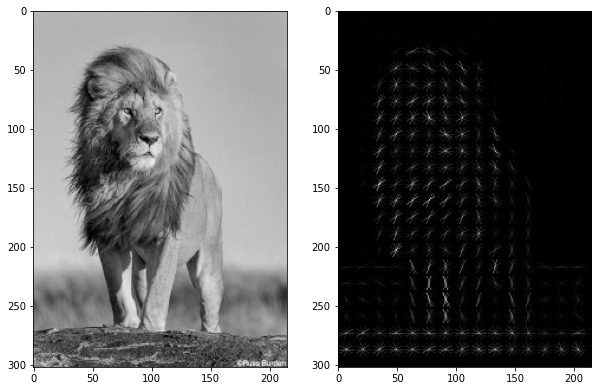

In [12]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,15))
ax1.imshow(gray, cmap='gray')
ax2.imshow(hog_img, cmap='gray')

In [13]:
class rgb2gray_transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return [skimage.color.rgb2gray(x) for x in X]

In [14]:
rgb2gray_obj = rgb2gray_transform()
X_train_gray = rgb2gray_obj.fit_transform(X_train)

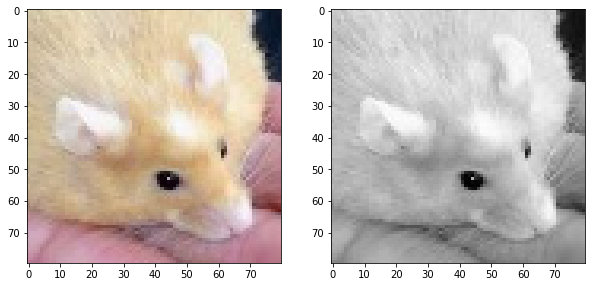

In [15]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,15))
ax1.imshow(X_train[0])
ax2.imshow(X_train_gray[0], cmap='gray')

## visualize hog

In [16]:
class hogtransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, 
                 pixels_per_cell=(8, 8), 
                 cells_per_block=(3, 3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X, y=None):
        def local_hog(img):
            hog_feature, hog_img = skimage.feature.hog(
                img,
                orientations= self.orientations,
                pixels_per_cell= self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                visualize=True)
            return hog_img
        # hog_features = np.array([local_hog(x)[0] for x in X])
        hog_img = np.array([local_hog(x) for x in X])
        return hog_img

In [17]:
hogt = hogtransformer()
X_train_hog = hogt.fit_transform(X_train_gray)

In [18]:
X_train_hog.shape

(1618, 80, 80)

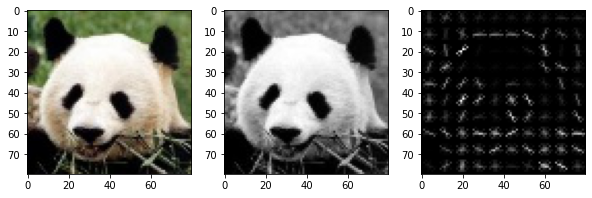

In [19]:
f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,15))
ax1.imshow(X_train[10], cmap='gray')
ax2.imshow(X_train_gray[10], cmap='gray')
ax3.imshow(X_train_hog[10], cmap='gray')

##  Hog feature

In [20]:
class hogtransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, 
                 pixels_per_cell=(8, 8), 
                 cells_per_block=(3, 3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X, y=None):
        def local_hog(img):
            hog_feature = skimage.feature.hog(img,
                orientations= self.orientations,
                pixels_per_cell= self.pixels_per_cell,
                cells_per_block=self.cells_per_block)
            return hog_feature
        hog_features = np.array([local_hog(x) for x in X])
        # hog_img = np.array([local_hog(x) for x in X])
        return hog_features

In [21]:
hogt = hogtransformer()
X_train_hog = hogt.fit_transform(X_train_gray)

## Training Machine Learning Model 

In [22]:
model_sgd = SGDClassifier(loss='hinge',
                          learning_rate='adaptive',
                          early_stopping=True, eta0=0.1)

In [23]:
# pipeline
X_train.shape, X_test.shape

((1618, 80, 80, 3), (405, 80, 80, 3))

In [24]:
gray_t = rgb2gray_transform()
hog_t = hogtransformer()
scale_t = StandardScaler()

In [25]:
# pipeline
# step-1: Convert into grayscale
x_train_gray = gray_t.fit_transform(X_train)
# step-2: extract the feature
x_train_hog = hog_t.fit_transform(x_train_gray)
# step-3: Normalization 
X_train_scale = scale_t.fit_transform(x_train_hog)
# step-4: machine learning 
model_sgd.fit(X_train_scale, y_train)

SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='adaptive')

In [26]:
# step-1: Convert into grayscale
x_test_gray = gray_t.fit_transform(X_test)
# step-2: extract the feature
x_test_hog = hog_t.fit_transform(x_test_gray)
# step-3: Normalization 
X_test_scale = scale_t.fit_transform(x_test_hog)
# step-4: machine learning 
y_pred_test = model_sgd.predict(X_test_scale)

In [28]:
# y_pred_test

## Model Evaluation 

In [30]:
cr = sklearn.metrics.classification_report(y_test, 
                                      y_pred_test, 
                                      output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.583333,0.350000,0.437500,20.000000
cat,0.605263,0.718750,0.657143,32.000000
chicken,0.636364,0.700000,0.666667,20.000000
cow,0.434783,0.500000,0.465116,20.000000
deer,0.555556,0.500000,0.526316,20.000000
dog,0.400000,0.370370,0.384615,27.000000
duck,0.521739,0.600000,0.558140,20.000000
eagle,0.600000,0.473684,0.529412,19.000000
elephant,0.523810,0.550000,0.536585,20.000000
human,0.545455,0.900000,0.679245,20.000000


In [31]:
metrics.cohen_kappa_score(y_test, y_pred_test)

0.4938934838061374

In [33]:
#

## Pipeline Model

In [34]:
model_pipe = Pipeline([
    ('grayscale', rgb2gray_transform()),
    ('hogtransform', hogtransformer(orientations=8, 
                                    pixels_per_cell=(10,10),
                                    cells_per_block=(3,3))),
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='hinge', 
                          learning_rate='adaptive', 
                          early_stopping=True, 
                          eta0=0.1))
])

In [35]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('grayscale', rgb2gray_transform()),
                ('hogtransform',
                 hogtransformer(orientations=8, pixels_per_cell=(10, 10))),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(early_stopping=True, eta0=0.1,
                               learning_rate='adaptive'))])

In [36]:
y_pred_test = model_pipe.predict(X_test)

In [40]:
cr = sklearn.metrics.classification_report(y_test,
                                      y_pred_test, 
                                      output_dict=True)

pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.357143,0.250000,0.294118,20.000000
cat,0.625000,0.625000,0.625000,32.000000
chicken,0.478261,0.550000,0.511628,20.000000
cow,0.411765,0.350000,0.378378,20.000000
deer,0.521739,0.600000,0.558140,20.000000
dog,0.470588,0.592593,0.524590,27.000000
duck,0.684211,0.650000,0.666667,20.000000
eagle,0.538462,0.368421,0.437500,19.000000
elephant,0.608696,0.700000,0.651163,20.000000
human,0.695652,0.800000,0.744186,20.000000


In [41]:
#

## Grid Search

In [44]:
# Hyperperameter tunning 